## Training

This section described the training of three separate models: the Length classifier, the AAC classifier, and the PLM classifier. Each model is trained for 10 epochs on a dataset of roughly 50,000 UniProt sequences, using the Binary Cross-Entropy loss training objective. The result of this procedure is a set of trained weights for each model, which can be saved and re-loaded as needed.

**NOTE:** The steps described in this notebook are not necessary for replicating Seplmobot results. Pre-trained models, as well as completed training, testing, and validation datasets are available in a Google Cloud bucket, and instructions for downloading them can be found in the `testing.ipynb` and `training.ipynb` notebooks.

If you want to run this code, be sure to modify the `DATA_DIR` variable below to specify where the data will be stored on your machine. `DATA_DIR` is the absolute path specifying the location where the data will be stored


In [1]:
# So you don't need to restart the kernel whenever a module is updated.
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = '/home/prichter/Documents/data/selenobot/'

In [27]:
import sys
# Add the seplmobot/ subirectory to the module search path, so that the modules in this directory are visible from the notebook.
sys.path.append('../selenobot/')

from dataset import Dataset, get_dataloader 
from embedders import AacEmbedder, LengthEmbedder
from classifiers import Classifier, SimpleClassifier
from utils import csv_size
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch

# Some specs for plotting.
TITLE_FONT_SIZE, LABEL_FONT_SIZE = 10, 10
FIGSIZE = (4, 3)
# Set all matplotlib global parameters.
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':LABEL_FONT_SIZE})
plt.rc('xtick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('ytick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('axes',  **{'titlesize':TITLE_FONT_SIZE, 'labelsize':LABEL_FONT_SIZE})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

## Downloading the training and validation datasets

Prepared training and validation datasets are available for download from a Google Cloud bucket. The training dataset consists of __ UniProt sequences and PLM embeddings,  __ percent of which are truncated selenoproteins. The validation dataset contains __ sequences and embeddings,  __ percent of which are truncated selenoproteins. These datasets can be accessed using the commands below. Alternatively, these datasets can be generated from scratch by following the procedure in the `setup.ipynb` notebook.


In [4]:
# Uncomment this code to download the training data from Google Cloud.
# ! curl https://storage.googleapis.com/selenobot-data/train.csv -o '{DATA_DIR}train.csv'
# Uncomment this code to download the validation data from Google Cloud.
# ! curl https://storage.googleapis.com/selenobot-data/val.csv -o '{DATA_DIR}val.csv'

In [5]:
# Print some information about the size of each dataset.
print('Size the training dataset:', csv_size(f'{DATA_DIR}train.csv'))
print('Size of the validation dataset:', csv_size(f'{DATA_DIR}val.csv'))

Size the training dataset: 470830
Size of the validation dataset: 47089


In [6]:
# Print some information about the selenoprotein content of each dataset.
train_labels = pd.read_csv(f'{DATA_DIR}train.csv', usecols=['label']).label
val_labels = pd.read_csv(f'{DATA_DIR}val.csv', usecols=['label']).label 

print('Selenoprotein content of the training dataset:', np.sum(train_labels) / len(train_labels))
print('Selenoprotein content of the validation dataset:', np.sum(val_labels) / len(val_labels))

Selenoprotein content of the training dataset: 0.03255952254529235
Selenoprotein content of the validation dataset: 0.021321327698613265


## Instantiating `Dataset`s

Datasets are Pytorch objects which store data and provide a consistent interface for accessing that data. For the Selenobot project, we define custom `Dataset` objects which provide extra functionality for producing sequence embeddings and accessing information about selenoprotein content. The custom `Dataset`s take a pandas `DataFrame` and an `Embedder` object as input (either a `LengthEmbedder` or `AacEmbedder`). The embedder will be applied to the sequences in the `DataFrame`, and the resulting vectors stored in the `embeddings` attribute of the `Dataset`. If no embedder is specified, it is assumed that the embeddings are already contained in the input DataFrame, and are extracted into the embeddings attribute (this is necessary when using PLM embeddings, as they cannot be generated *ad hoc* due to computational cost). 

For training, three `Datasets` are instantiated using the training data. Each `Dataset` uses a different embedder: one to train the AAC classifier, one to train the length classifier, and one to train the Selenobot (PLM embedding-based) classifier. For each of these `Dataset`s, a corresponding `Dataset` (with the same embedder) is created to store the validation data. 


In [7]:
# Load the validation and training data into pandas DataFrames.
# Make sure to specify the index column to avoid reading in an "Unnamed" column.
train_df = pd.read_csv(f'{DATA_DIR}train.csv', index_col=0)
val_df = pd.read_csv(f'{DATA_DIR}val.csv', index_col=0)

In [8]:
len_train_dataset = Dataset(train_df, embedder=LengthEmbedder())
len_val_dataset = Dataset(val_df, embedder=LengthEmbedder())

aac_train_dataset = Dataset(train_df, embedder=AacEmbedder())
aac_val_dataset = Dataset(val_df, embedder=AacEmbedder())

plm_train_dataset = Dataset(train_df, embedder=None)
plm_val_dataset = Dataset(val_df, embedder=None)

## Instantiating `DataLoader`s

Model training is mediated by Pytorch `DataLoaders`, which are objects that facilitate batch training. In order to address the imbalance in the training data (many more full-length proteins than truncated selenoproteins), we implemented a custom Pytorch `BatchSampler`, called  `BalancedBatchSampler`, which is defined in the `dataset.py` file. `BalancedBatchSampler` is used in conjunction with the `DataLoaders` to ensure that each batch has an equal number of truncated selenoproteins and non-selenoproteins. It does so by repeatedly resampling from the training data, using the algorithm described in the `dataset.py` file. 

`DataLoaders` are created using the `get_dataloader` function, which takes a `Dataset` as input, and returns a balanced-batch `DataLoader` object with the specified batch size. For all models in this investigation, we used batches of size 1024. No other batch sizes were tested. 

In [9]:
# Store the batch size.
batch_size = 1024

In [10]:
# Instantiate DataLoaders for each training Dataset.
len_dataloader = get_dataloader(len_train_dataset, batch_size=batch_size)
aac_dataloader = get_dataloader(aac_train_dataset, batch_size=batch_size)
plm_dataloader = get_dataloader(plm_train_dataset, batch_size=batch_size)

dataset.BalancedBatchSampler.__init__: Resampled 439838 selenoproteins and removed 332 non-selenoproteins to generate 889 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 439838 selenoproteins and removed 332 non-selenoproteins to generate 889 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 439838 selenoproteins and removed 332 non-selenoproteins to generate 889 batches of size 1024.


## Training the models

Two types of classifiers are used in this investigation: the `Classifier` (for AAC and PLM embeddings) and the `SimpleClassifier` (for length embeddings). Each of these models is defined in the `classifiers.py` file. Both classes implement a fit method, which takes a `DataLoader` and validation `Dataset` as input, as well as other parameters such as learning rate and epochs. This method trains the model using the `DataLoader`, and returns a `TrainReporter` object, which stores information regarding model performance during the training process. Details of the model training procedures are provided below.
1. **Epochs** Initially, all models were trained for 10 epochs. Examining the training curves reveals that overtraining occurs past 4 epochs for the PLM classifier, and after 2 epochs for the length classifier. Epoch numbers are adjusted accordingly.
2. **Learning rate: 0.001** Several learning rates were attempted, and it was found that a smaller learning rate produced a smoother training curve.
3. **Loss function: Binary cross-entropy (BCE) loss** We also tried a weighted BCE loss function, penalizing instances of false negatives (a truncated selenoprotein classified as full-length) more heavily than false negatives (a full-length protein classified as truncated). We found that this did little to improve model performance, so opted for unweighted BCE loss.

Upon completion, the weights of the trained models are stored as PTH files using the PyTorch save method. The `TrainReporter` objects are stored using the Python pickle module. The balanced accuracy on the training and validation datasets is then computed for each trained model using the `predict` method.



In [11]:
# Instantiate each model with the appropriate dimensions.
len_model = SimpleClassifier(latent_dim=1, random_seed=42)
aac_model = Classifier(latent_dim=21, hidden_dim=8, random_seed=42)
plm_model = Classifier(latent_dim=1024, hidden_dim=512, random_seed=42)

In [12]:
# Store variables for the learning rate and number of epochs.
# The BCE loss function is built in to the Classifier objects, so does not need to be explicitly set.
lr = 0.001
# Ended up using variable numbers of epochs to avoid overfitting. 
# epochs = 10 

In [13]:
len_reporter = len_model.fit(len_dataloader, val_dataset=len_val_dataset, epochs=2, lr=lr)
# Save the Reporter object using pickle.
with open(f'{DATA_DIR}len_reporter.pkl', 'wb') as f:
        pickle.dump(len_reporter, f)
# Save the weights of the trained model. 
torch.save(len_model.state_dict(), f'{DATA_DIR}len_model_weights.pth')

len_train_acc = len_model.predict(len_train_dataset).get_balanced_accuracy()
len_val_acc = len_model.predict(len_val_dataset).get_balanced_accuracy()
print('Length classifier balanced accuracy on training dataset:', len_train_acc)
print('Length classifier balanced accuracy on validation dataset:', len_val_acc)

classifiers.Classifier.fit: 100%|██████████| 2/2 [00:25<00:00, 12.52s/it, val_loss=0.64, train_loss=0.684]


Length classifier balanced accuracy on training dataset: 0.5573366600719051
Length classifier balanced accuracy on validation dataset: 0.5923409540745557


In [14]:
aac_reporter = aac_model.fit(aac_dataloader, val_dataset=aac_val_dataset, epochs=10, lr=lr)
# Save the Reporter object using pickle.
with open(f'{DATA_DIR}aac_reporter.pkl', 'wb') as f:
        pickle.dump(aac_reporter, f)
# Save the weights of the trained model. 
torch.save(aac_model.state_dict(), f'{DATA_DIR}aac_model_weights.pth')

aac_train_acc = aac_model.predict(aac_train_dataset).get_balanced_accuracy()
aac_val_acc = aac_model.predict(aac_val_dataset).get_balanced_accuracy()
print('AAC classifier balanced accuracy on training dataset:', aac_train_acc)
print('AAC classifier balanced accuracy on validation dataset:', aac_val_acc)

classifiers.Classifier.fit:   0%|          | 0/10 [00:00<?, ?it/s]

classifiers.Classifier.fit: 100%|██████████| 10/10 [02:11<00:00, 13.12s/it, val_loss=0.512, train_loss=0.494]


AAC classifier balanced accuracy on training dataset: 0.7788623148400753
AAC classifier balanced accuracy on validation dataset: 0.7539824968326758


In [15]:
plm_reporter = plm_model.fit(plm_dataloader, val_dataset=plm_val_dataset, epochs=4, lr=lr)
# Save the Reporter object using pickle.
with open(f'{DATA_DIR}plm_reporter.pkl', 'wb') as f:
        pickle.dump(plm_reporter, f)
# Save the weights of the trained model. 
torch.save(plm_model.state_dict(), f'{DATA_DIR}plm_model_weights.pth')

plm_train_acc = plm_model.predict(plm_train_dataset).get_balanced_accuracy()
plm_val_acc = plm_model.predict(plm_val_dataset).get_balanced_accuracy()
print('PLM classifier balanced accuracy on training dataset:', plm_train_acc)
print('PLM classifier balanced accuracy on validation dataset:', plm_val_acc)

classifiers.Classifier.fit: 100%|██████████| 4/4 [05:13<00:00, 78.30s/it, val_loss=0.0012, train_loss=0.0021]


PLM classifier balanced accuracy on training dataset: 0.9995203073545554
PLM classifier balanced accuracy on validation dataset: 0.9978452253695428


## Visualizing the training process 

The `plot.py` module defines a set of functions for visualizing the training data stored in the Reporter objects. The `plot_train_curve` function takes a `TrainReporter` as input, and displays the BCE loss (optionally on a log-scale) at each epoch. 


In [28]:
def plot_training_curve(reporter:TrainReporter, logscale:bool=True) -> plt.Axes:
    '''Plots a training curve using information stored in a TrainReporter object.
    
    :param reporter: The TrainReporter object containing the information from model training. 
    :param logscale: Whether or not to use log scale on the y-axis.
    '''
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    ax = sns.lineplot(data=reporter.get_training_curve_data(), y='value', x='epoch', hue='metric', ax=ax, palette=PALETTE, style='metric')
    ax.legend().set_title('') # Turn off legend title because it looks crowded. 

    # Add horizontal lines designating epochs.
    for x in range(reporter.epochs):
        ax.axvline(x=x, ymin=0, ymax=1, color='gray', ls=(0, (1, 3)), lw=1)

    if logscale:
        ax.set_ylabel('log(loss)')
        plt.yscale('log')
    else:
        ax.set_ylabel('loss')

    ax.legend(fontsize=LABEL_FONT_SIZE, bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5)
    return ax


In [29]:
# If the Jupyter kernel has been restarted, uncomment and run this code to load the pickled TrainReporter objects.

# with open(f'{DATA_DIR}len_reporter.pkl', 'rb') as f:
#         len_reporter = pickle.load(f)

# with open(f'{DATA_DIR}aac_reporter.pkl', 'rb') as f:
#         aac_reporter = pickle.load(f)

# with open(f'{DATA_DIR}plm_reporter.pkl', 'rb') as f:
#         plm_reporter = pickle.load(f)

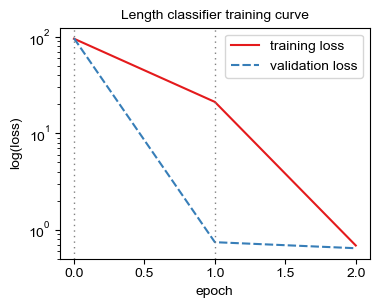

In [30]:
# Plot the performance of the model during training. 
ax = plot_training_curve(len_reporter)
ax.set_title('Length classifier training curve')
plt.show()

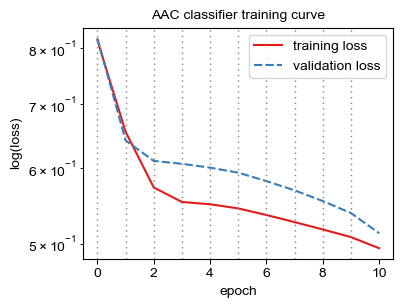

In [31]:
# Plot the performance of the model during training. 
ax = plot_training_curve(aac_reporter)
ax.set_title('AAC classifier training curve')
plt.show()

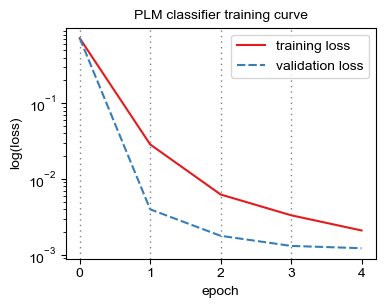

In [32]:
# Plot the performance of the model during training. 
ax = plot_training_curve(plm_reporter)
ax.set_title('PLM classifier training curve')
plt.show()

## Calibrating the PLM classifier

Model calibration refers to the process of ensuring that model output is representative of the true correctness likelihood. Model calibration is an important and often-overlooked step in model training. It tends to be an issue primarily with higher-capacity models, with many layers. Nonetheless, it is worthwhile to assess the calibration of our simple binary classifier. We characterize model calibration using two methods.
1. **Calibration curve** Calibration curves are generated by binning a set of model predictions into bins of equal width. The mean prediction in each bin is then plotted against the fraction of positive samples in the bin. The values displayed were computed using the ScikitLearn `calibration_curve` function. 
2. **Expected calibration error (ECE)** ECE is calculated by first  binning a set of model predictions into equal-width bins. Bin accuracy (bin_acc) is defined to be the mean of the fraction of positive samples in the bin, and bin confidence (bin_conf) is defined to be the mean prediction in the bin. ECE is a weighted sum of |bin_acc - bin_conf| over all bins, with the weight of each bin being the number of samples in the bin divided by the total number of samples. ECE is calculated using the `get_expected_calibration_error` function in the `reporters.py` module. 

The `plot_calibration_curve` and `get_expected_calibration_error` functions require a `TestReporter` object, which is produced by calling a `Classifier`'s `predict` method. `TestReporter` objects store model outputs and targets, and manage the calculation of several evaluation metrics (including ECE). Calibration is assessed using the validation dataset [9].

In [33]:
 def plot_calibration_curve(reporter:TestReporter, ax:plt.Axes=None, n_bins:int=10) -> plt.Axes:
    '''Plots a reliability curve using data in the Reporter object.

    :param reporter: The TestReporter object containing the information from model testing. 
    :param ax: If specified, the matplotlib Axes to add the plot to. 
    :param nbins: The number of bins to use when generating data for the calibration curve.
    '''
    if ax is None: # Create a new set of Axes if none are specified. 
        fig, ax = plt.subplots(ax, figsize=FIGSIZE) 

    # Reporter stores Sigmoid outputs from the classifier (threshold not applied).
    prob_true, prob_pred = calibration_curve(reporter.targets, reporter.outputs, n_bins=n_bins, strategy='quantile')
    
    # prob_true is the proportion of samples whose class is the positive class in each bin (the y-axis).
    # prob_pred is the mean predicted probability in each bin (the x-axis).

    ax.plot(prob_pred, prob_true)
    ax.set_xlabel('mean predicted probability')
    ax.set_ylabel('fraction of positives')

In [34]:
# If the kernel has been restarted, uncomment and run this cell to load the weights of trained models to avoid needing to re-train.

# Instantiate each model with the appropriate dimensions.
len_model = SimpleClassifier(latent_dim=1)
aac_model = Classifier(latent_dim=21, hidden_dim=8)
plm_model = Classifier(latent_dim=1024, hidden_dim=512)

# Load the weights from the saved pth files into the appropriate model.
len_model.load_state_dict(torch.load(f'{DATA_DIR}len_model_weights.pth'))
aac_model.load_state_dict(torch.load(f'{DATA_DIR}aac_model_weights.pth'))
plm_model.load_state_dict(torch.load(f'{DATA_DIR}plm_model_weights.pth'))


<All keys matched successfully>

In [35]:
# Create TestReporter objects for each model on the validation datasets.
len_test_reporter = len_model.predict(len_val_dataset)
aac_test_reporter = aac_model.predict(aac_val_dataset)
plm_test_reporter = plm_model.predict(plm_val_dataset)

: 

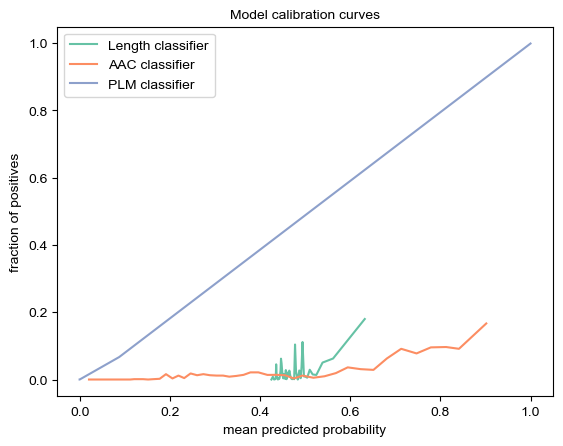

In [22]:
n_bins = 50
fig, ax = plt.subplots()
plot_calibration_curve(len_test_reporter, ax=ax, n_bins=n_bins)
plot_calibration_curve(aac_test_reporter, ax=ax, n_bins=n_bins)
plot_calibration_curve(plm_test_reporter, ax=ax, n_bins=n_bins)
ax.legend(['Length classifier', 'AAC classifier', 'PLM classifier'])
ax.set_title('Model calibration curves')

plt.show()

In [23]:
print('Expected calibration error of length classifier:', len_test_reporter.get_expected_calibration_error())
print('Expected calibration error of AAC classifier:', aac_test_reporter.get_expected_calibration_error())
print('Expected calibration error of PLM classifier:', plm_test_reporter.get_expected_calibration_error())

Expected calibration error of length classifier: 0.4498562368596209
Expected calibration error of AAC classifier: 0.32415621222102203
Expected calibration error of PLM classifier: 0.00045152453399207074



The calibration curve and ECE of the PLM classifier indicate the model is already calibrated. No calibration techniques are applied to the model. 